<a href="http://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07B%20-%20Text%20Classification%20Deep%20Learning%20CNN%20Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 KB 4.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load Movie Review Dataset

In [ ]:
dataset = pd.read_csv('./drive/MyDrive/filtered.csv')
dataset = dataset[dataset.Sentiment != 'neutral']
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189 entries, 0 to 297
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   MovieId      189 non-null    object
 1   UserReviews  189 non-null    object
 2   Sentiment    189 non-null    object
dtypes: object(3)
memory usage: 5.9+ KB


In [ ]:
dataset.head()

,MovieId,UserReviews,Sentiment
0,tt5918982,Tasya Vos (Andrea Riseborough) is the Possesso...,negative
1,tt5918982,Some artful notions swirling around in this on...,negative
4,tt5918982,There aren't enough people doing this kind of ...,positive
5,tt5918982,One of the greatest directors from the 70s for...,positive
7,tt5918982,The incipit is really good: an agency that per...,negative


### Prepare Train Test Split

In [ ]:
reviews = dataset['UserReviews'].values
sentiments = dataset['Sentiment'].values

train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(reviews,sentiments,test_size=0.25, random_state=42)

In [ ]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('lame', 2288), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(train_reviews)

In [ ]:
test_sequences = t.texts_to_sequences(test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=2289
Number of Documents=141


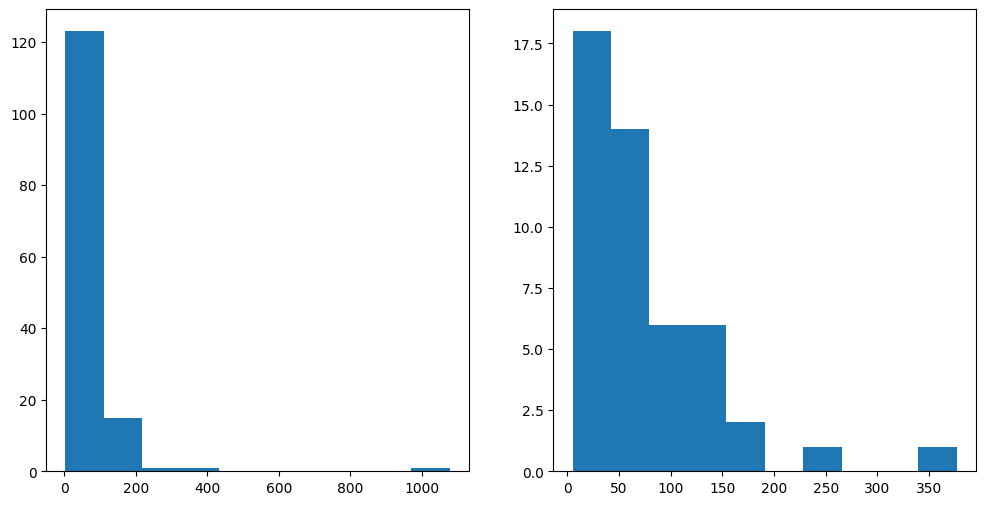

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [ ]:
MAX_SEQUENCE_LENGTH = 1000

In [ ]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((141, 1000), (48, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [ ]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [ ]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
VOCAB_SIZE = len(t.word_index)

## Prepare the Model

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [ ]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1000, 300)         686700    
                                                                 
 conv1d_6 (Conv1D)           (None, 1000, 128)         153728    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 500, 128)         0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 500, 64)           32832     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 250, 64)          0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 250, 32)          

## Model Training

In [ ]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
1/1 [==============================] - 2s 2s/step - loss: 0.7002 - accuracy: 0.2937 - val_loss: 0.6463 - val_accuracy: 0.6667
Epoch 2/2
1/1 [==============================] - 0s 136ms/step - loss: 0.6261 - accuracy: 0.7063 - val_loss: 0.7093 - val_accuracy: 0.6667


## Model Evaluation

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

2/2 [==============================] - 0s 10ms/step - loss: 0.5467 - accuracy: 0.7708
Accuracy: 77.08%


In [ ]:
print(X_test)

[[   0    0    0 ...    4 1727   22]
 [   0    0    0 ...  122  105  158]
 [   0    0    0 ...  265   29  111]
 ...
 [   0    0    0 ...    7  174   70]
 [   0    0    0 ...    3   24    1]
 [   0    0    0 ...    6   13  139]]


In [ ]:
predictions = model.predict(X_test)
classes_x = np.argmax(predictions,axis=1)
predictions[:10]

2/2 [==============================] - 0s 8ms/step


array([[0.17732689],
       [0.17876896],
       [0.17937087],
       [0.17678915],
       [0.17782605],
       [0.18065186],
       [0.18147722],
       [0.17608677],
       [0.17728642],
       [0.17571835]], dtype=float32)

In [ ]:
predictions = ['positive' if item == 1 else 'negative' for item in predictions]
predictions[:10]

['negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative']

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.77      1.00      0.87        37
    positive       0.00      0.00      0.00        11

    accuracy                           0.77        48
   macro avg       0.39      0.50      0.44        48
weighted avg       0.59      0.77      0.67        48



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,negative,positive
negative,37,0
positive,11,0
